In [7]:
%load_ext autoreload
%autoreload 2
%pylab inline
import sys
sys.path.insert(0,'../../tests/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [8]:
import tensorflow as tf
import flowpm
from test_raytracing import *

## Testing density extraction from snapshots

In [12]:
# This is the content of test density plane
fpm_plane, lt_plane, smooth_fpm_plane, smooth_lt_plane = test_density_plane(return_results=True)

[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 50. Mpc/h>]
HELLO 50.0 Mpc/h 324.4441223144531 Mpc/h 0.9
TOTAL PART:  65677.0
[<Quantity 3.125 Mpc/h>, <Quantity 3.125 Mpc/h>, <Quantity 50. Mpc/h>]
cosmo, density 2.354969644863748e-08 1 / Mpc2 18024.673461914062 Mpc/h2


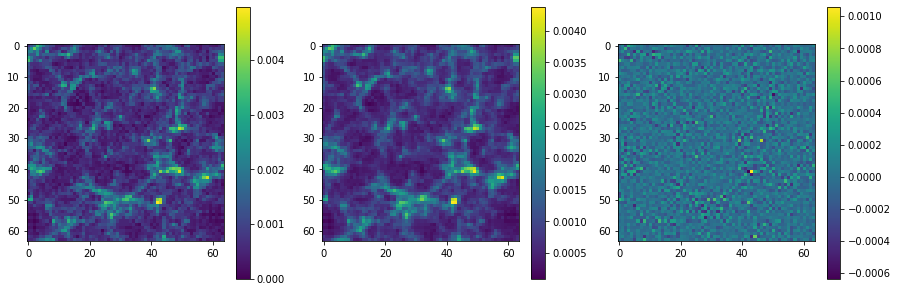

In [13]:
# Showing the comparison of non-smooth fields
figure(figsize=[15,5])
subplot(131)
imshow(lt_plane)
colorbar()
subplot(132)
imshow(fpm_plane[0])
colorbar()
subplot(133)
imshow(lt_plane - fpm_plane[0])
colorbar()

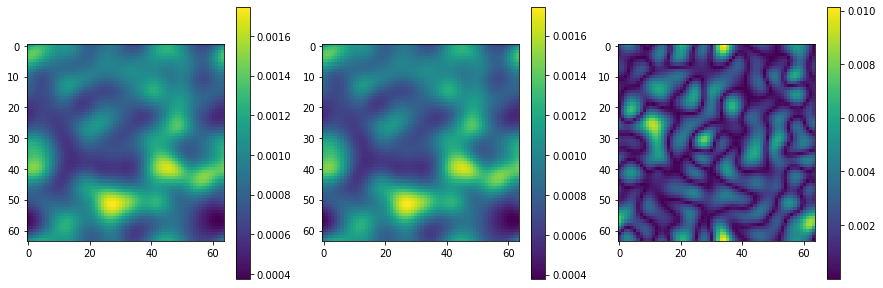

In [17]:
# Showing the comparison of smoothed fields
figure(figsize=[15,5])
subplot(131)
imshow(smooth_lt_plane)
colorbar()
subplot(132)
imshow(smooth_fpm_plane)
colorbar()
subplot(133)
imshow(abs(smooth_lt_plane - smooth_fpm_plane)/smooth_lt_plane)
colorbar()

In [18]:
def radial_profile(power_spectrum_2d):
    """
    Compute the radial profile of 2d image
    :param data: 2d image
    :return: radial profile
    """
    center = power_spectrum_2d.shape[0]/2
    v, u = np.indices((power_spectrum_2d.shape))
    k = np.sqrt((u - center)**2 + (v - center)**2)
    k = k.astype('int32')

    tbin = np.bincount(k.ravel(), power_spectrum_2d.ravel())
    nr = np.bincount(k.ravel())
    radialprofile = tbin / nr
    return radialprofile

def measure_power_spectrum(map_data, pixel_size, resolution):
    """
    measures power 2d data
    :param map_data: map (n x n)
    :param pixel_size: pixel size (rad/pixel)
    :return: ell
    :return: power spectrum
    """
    data_ft = np.abs(np.fft.fft2(map_data))
    data_ft_shifted = np.fft.fftshift(data_ft) 
    power_spectrum_2d = np.abs(data_ft_shifted * np.conjugate(data_ft_shifted)) / 512**2
    nyquist = np.int(data_ft_shifted.shape[0] / 2)
    radialprofile = radial_profile(power_spectrum_2d)
    power_spectrum_1d = radialprofile[:nyquist] * (pixel_size)**2

    # Convert frequencies to angular multipoles \ell
    k = np.arange(power_spectrum_1d.shape[0])
    ell = 2. * np.pi * k / pixel_size / 360

    return ell, power_spectrum_1d

In [31]:
_, ps1 = measure_power_spectrum(smooth_lt_plane, 1., 64)
_, ps2 = measure_power_spectrum(smooth_fpm_plane, 1., 64)

(1e-22, 1e-06)

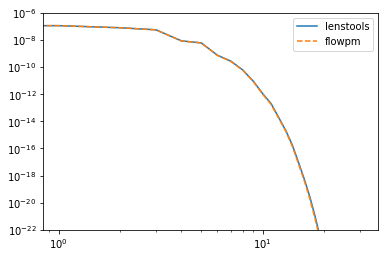

In [32]:
loglog(ps1, label='lenstools')
loglog(ps2, '--', label='flowpm')
legend()
ylim(1e-22,1e-6)